<a href="https://colab.research.google.com/github/wolfram-laube/mlpc-project_team-park/blob/wl/task_4/fastlane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preparation: Distiguish Environment and Establish Prerequisites



#### Libraries With Specific Handling

In [1]:
import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    # Installation script for Google Colab
    print("Running in Google Colab. Installing RAPIDS...")
    !nvidia-smi
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
    !bash rapidsai-csp-utils/colab/rapids-colab.sh 23.02
    sys.path.append('/usr/local/lib/python3.8/site-packages/')
else:
    # Local machine setup
    print("Running on local machine. Checking cuml installation...")
    try:
        import cuml
        print("cuml is already installed.")
    except ImportError:
        # Adapt these commands to your local environment
        print("Installing cuml locally using conda...")
        !conda create -n rapids -c rapidsai -c nvidia -c conda-forge cuml=23.02 python=3.8 cudatoolkit=11.2 -y
        !conda activate rapids
        sys.path.append('/path/to/conda/env/lib/python3.X/site-packages/')

# Example imports for RAPIDS libraries
try:
    import cuml
    import cudf
    print("cuML version: ", cuml.__version__)
    print("cuDF version: ", cudf.__version__)
except ImportError as e:
    print(e)
    print("Failed to import RAPIDS libraries. Check installation steps.")

Running on local machine. Checking cuml installation...
Installing cuml locally using conda...
zsh:1: command not found: conda
zsh:1: command not found: conda
No module named 'cuml'
Failed to import RAPIDS libraries. Check installation steps.


#### Setup Folder Structure

In [2]:
import os
import sys
import shutil

# Check if the environment is Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # If in Google Colab
    from google.colab import drive
    import gdown

    # Option 1: Download the file by its public link and expand it to the Colab runtime
    import urllib.request
    import zipfile

    wavzip_file_id = '1oI1EsH1krrEPbH9MSZRzLHu-_4p6-njR' # https://drive.google.com/file/d/1oI1EsH1krrEPbH9MSZRzLHu-_4p6-njR/view?usp=sharing
    npyzip_file_id = '1oKgurvIgT93RGkxvxq8AA423VKlEVT7O' # https://drive.google.com/file/d/1oKgurvIgT93RGkxvxq8AA423VKlEVT7O/view?usp=sharing
    annotation_file_id = '1xLxget7c5nCkwYt9Ru2RpYi5rMkk_pl0'  # https://drive.google.com/file/d/1xLxget7c5nCkwYt9Ru2RpYi5rMkk_pl0/view?usp=sharing
    scenes_file_id = '1xLgB7-cCz6nReyQbFJJcJGOUKCCbNhCG'  # https://drive.google.com/file/d/1xLgB7-cCz6nReyQbFJJcJGOUKCCbNhCG/view?usp=sharing

    wavzip_url = f'https://drive.google.com/uc?id={wavzip_file_id}'
    npyzip_url = f'https://drive.google.com/uc?id={npyzip_file_id}'
    annotation_url = f'https://drive.google.com/uc?id={annotation_file_id}'
    scenes_url = f'https://drive.google.com/uc?id={scenes_file_id}'

    wavzip_path = '/content/training_data.zip'
    npyzip_path = '/content/training_feat.zip'
    data_dir = '/content/dataset'
    scenes_dir = f'{data_dir}/scenes'
    words_dir = f'{data_dir}/words'
    scenes_wav_dir = f'{scenes_dir}/wav'
    scenes_npy_dir = f'{scenes_dir}/npy'

    # Download the WAVZIP file
    #urllib.request.urlretrieve(wavzip_url, wavzip_path)
    gdown.download(wavzip_url, wavzip_path, quiet=False)

    # Unzip the file
    with zipfile.ZipFile(wavzip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

    print(f"Training data extracted to {data_dir}")

     # Create the 'scenes/wav' folder structure
    os.makedirs(scenes_wav_dir, exist_ok=True)

    # Copy .wav files to 'scenes/wav'
    extracted_scenes_dir = os.path.join(data_dir, 'mlpc24_speech_commands', 'scenes')
    for root, dirs, files in os.walk(extracted_scenes_dir):
        for file in files:
            if file.endswith('.wav'):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(scenes_wav_dir, file)
                shutil.copy(src_path, dst_path)

    print(f".wav files moved to {scenes_wav_dir}")

    # Download the NPYZIP file
    #urllib.request.urlretrieve(npyzip_url, npyzip_path)
    gdown.download(npyzip_url, npyzip_path, quiet=False)

    # Unzip the file
    with zipfile.ZipFile(npyzip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

    print(f"Training features extracted to {data_dir}")

     # Create the 'scenes/npy' folder structure
    os.makedirs(scenes_npy_dir, exist_ok=True)

    # Copy .npy files to 'scenes/npy'
    extracted_scenes_dir = os.path.join(data_dir, 'development_scenes')
    for root, dirs, files in os.walk(extracted_scenes_dir):
        for file in files:
            if file.endswith('.npy'):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(scenes_npy_dir, file)
                shutil.copy(src_path, dst_path)

    print(f".npy files moved to {scenes_npy_dir}")

    # Download the CSV files into the data_dir
    annotation_orig_path = os.path.join(data_dir, 'development_scene_annotations.csv.orig') # Keep a bckup copy because it needs fixing
    annotation_path = os.path.join(data_dir, 'development_scene_annotations.csv')
    scenes_path = os.path.join(data_dir, 'development_scenes.csv')

    gdown.download(annotation_url, annotation_orig_path, quiet=False)
    gdown.download(annotation_url, annotation_path, quiet=False)
    gdown.download(scenes_url, scenes_path, quiet=False)

    print(f"CSV files downloaded to {scenes_dir}")

    # Option 2: Mount Google Drive and use the training data
    # Note this really takes some time for preprocessing file by file
    #drive.mount('/content/drive')
    #data_dir = '/content/drive/My Drive/Dropbox/public/mlpc/dataset'

    # Use this option to read from Google Drive instead
    #print(f"Using training data from {data_dir}")
else:
    # If on local machine
    data_dir = '../dataset'
    print(f"Using local training data from {data_dir}")

# Use the data_dir variable as the path to your training data

Using local training data from ../dataset


#### Fix Erreneous Metadata

##### Before

In [3]:
import pandas as pd

# Load the CSV files
scene_annotations_df = pd.read_csv(f'{data_dir}/development_scene_annotations.csv')
scenes_df = pd.read_csv(f'{data_dir}/development_scenes.csv')

# Check the head of the dataframes to understand their structure
print(scene_annotations_df.head())
print(scenes_df.head())

# Check the distribution of labels in the annotations CSV
label_distribution_annotations = scene_annotations_df['command'].value_counts()
print("Label Distribution in development_scene_annotations.csv:")
print(label_distribution_annotations)

# Check the distribution of speaker IDs in the scenes CSV
label_distribution_scenes = scenes_df['speaker_id'].value_counts()
print("Label Distribution in development_scenes.csv:")
print(label_distribution_scenes)


                        filename       command     start       end
0    1003_speech_false_Licht_aus     Licht aus  12.20090  13.57599
1       1008_speech_true_Ofen_an       Ofen an   6.90112   8.52638
2      1010_speech_true_Radio_an      Radio an  13.03100  14.03146
3  1011_speech_true_Fernseher_an  Fernseher an  14.11030  15.36121
4   1012_speech_true_Heizung_aus   Heizung aus  11.20520  12.70590
                        filename  speaker_id
0         2_speech_true_Ofen_aus         132
1         3_speech_true_Radio_an         132
2         4_speech_true_Alarm_an         132
3        9_speech_true_Radio_aus         132
4  11_speech_false_Fernseher_aus         132
Label Distribution in development_scene_annotations.csv:
command
Licht aus          86
Licht an           78
Heizung an         76
Fernseher an       74
Radio aus          69
Heizung aus        67
Alarm an           66
Radio an           65
Lüftung aus        64
Ofen aus           64
Ofen an            63
Staubsauger an     63

##### Fix

In [6]:
import os
import re
import shutil
import pandas as pd

# Paths to the original and working copy files
original_file_path = f'{data_dir}/development_scene_annotations.csv.orig'
working_copy_path = f'{data_dir}/development_scene_annotations.csv.0'
corrected_file_path = f'{data_dir}/development_scene_annotations.csv'

# Step 1: Create a working copy of the original file
shutil.copy(original_file_path, working_copy_path)

# Step 2: Load the working copy into a DataFrame
df = pd.read_csv(working_copy_path)

# Define the pattern to parse the filename
filename_pattern = re.compile(r'(\d+)_speech_(true|false)_((?:[a-zA-ZäöüÄÖÜß]+_(?:an|aus)_?)+)', re.UNICODE)

# Function to parse filename and extract commands
def parse_filename(filename):
    match = filename_pattern.match(filename)
    if not match:
        return []

    commands_str = match.group(3)
    commands = commands_str.split('_')

    command_list = []
    for i in range(0, len(commands), 2):
        command_list.append(f"{commands[i]} {commands[i+1]}")

    return command_list

# Parse the commands from filenames and add to the DataFrame
df['parsed_commands'] = df['filename'].apply(parse_filename)

# Step 3: Group by filename and sort by start time
grouped = df.groupby('filename').apply(lambda x: x.sort_values(by='start')).reset_index(drop=True)

# Step 4: Assign the correct labels based on the order of commands in the filename
def assign_labels(group):
    commands = group['parsed_commands'].iloc[0]  # get the parsed commands from the first row
    group = group.reset_index(drop=True)
    for i in range(len(group)):
        if i < len(commands):
            group.at[i, 'command'] = commands[i]
        else:
            print(f"Warning: More segments than commands in {group['filename'].iloc[0]}")
    return group

# Apply the label assignment function
corrected_df = grouped.groupby('filename').apply(assign_labels).reset_index(drop=True)

# Drop the temporary column
corrected_df = corrected_df.drop(columns=['parsed_commands'])

# Step 5: Save the corrected DataFrame to a new CSV file
corrected_df.to_csv(corrected_file_path, index=False)

# Verify the saved corrections
print("Label corrections applied and saved successfully.")
print(corrected_df.head())


Label corrections applied and saved successfully.
                        filename       command     start       end
0    1003_speech_false_Licht_aus     Licht aus  12.20090  13.57599
1       1008_speech_true_Ofen_an       Ofen an   6.90112   8.52638
2      1010_speech_true_Radio_an      Radio an  13.03100  14.03146
3  1011_speech_true_Fernseher_an  Fernseher an  14.11030  15.36121
4   1012_speech_true_Heizung_aus   Heizung aus  11.20520  12.70590


##### After

In [7]:
import pandas as pd

# Load the CSV files
scene_annotations_df = pd.read_csv(f'{data_dir}/development_scene_annotations.csv')
scenes_df = pd.read_csv(f'{data_dir}/development_scenes.csv')

# Check the head of the dataframes to understand their structure
print(scene_annotations_df.head())
print(scenes_df.head())

# Check the distribution of labels in the annotations CSV
label_distribution_annotations = scene_annotations_df['command'].value_counts()
print("Label Distribution in development_scene_annotations.csv:")
print(label_distribution_annotations)

# Check the distribution of speaker IDs in the scenes CSV
label_distribution_scenes = scenes_df['speaker_id'].value_counts()
print("Label Distribution in development_scenes.csv:")
print(label_distribution_scenes)


                        filename       command     start       end
0    1003_speech_false_Licht_aus     Licht aus  12.20090  13.57599
1       1008_speech_true_Ofen_an       Ofen an   6.90112   8.52638
2      1010_speech_true_Radio_an      Radio an  13.03100  14.03146
3  1011_speech_true_Fernseher_an  Fernseher an  14.11030  15.36121
4   1012_speech_true_Heizung_aus   Heizung aus  11.20520  12.70590
                        filename  speaker_id
0         2_speech_true_Ofen_aus         132
1         3_speech_true_Radio_an         132
2         4_speech_true_Alarm_an         132
3        9_speech_true_Radio_aus         132
4  11_speech_false_Fernseher_aus         132
Label Distribution in development_scene_annotations.csv:
command
Licht aus          86
Licht an           78
Heizung an         76
Fernseher an       74
Radio aus          69
Heizung aus        67
Alarm an           66
Radio an           65
Lüftung aus        64
Ofen aus           64
Ofen an            63
Staubsauger an     63

#### Determine CPU/GPU

In [9]:
# Function to check if GPU is available
#def is_gpu_available():
#    try:
#        result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#        return result.returncode == 0
#    except FileNotFoundError:
#        return False

def is_gpu_available():
    try:
        import torch
        return torch.cuda.is_available()
    except ImportError:
        pass

    try:
        import tensorflow as tf
        return tf.config.list_physical_devices('GPU') != []
    except ImportError:
        pass

    return False

### Step 1: Data Preprocessing

#### Load Metadata and Annotations


In [10]:
import pandas as pd

# Define file paths
metadata_file = f'{data_dir}/development_scenes.csv'
annotations_file = f'{data_dir}/development_scene_annotations.csv'

# Load the CSV files
metadata = pd.read_csv(metadata_file)
annotations = pd.read_csv(annotations_file)

print("Metadata:")
print(metadata.head())
print("\nAnnotations:")
print(annotations.head())


Metadata:
                        filename  speaker_id
0         2_speech_true_Ofen_aus         132
1         3_speech_true_Radio_an         132
2         4_speech_true_Alarm_an         132
3        9_speech_true_Radio_aus         132
4  11_speech_false_Fernseher_aus         132

Annotations:
                        filename       command     start       end
0    1003_speech_false_Licht_aus     Licht aus  12.20090  13.57599
1       1008_speech_true_Ofen_an       Ofen an   6.90112   8.52638
2      1010_speech_true_Radio_an      Radio an  13.03100  14.03146
3  1011_speech_true_Fernseher_an  Fernseher an  14.11030  15.36121
4   1012_speech_true_Heizung_aus   Heizung aus  11.20520  12.70590


#### Preprocess Audio Files (WAV) and Perform ICA


In [9]:
import os
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
import numpy as np
from IPython.display import Audio

# Define directories
scenes_wav_dir = f'{data_dir}/scenes/wav'  # Update this path

# Function to load and preprocess audio
def load_and_preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    scaler = StandardScaler()
    audio = scaler.fit_transform(audio.reshape(-1, 1)).flatten()

    ica = FastICA(n_components=1, whiten='unit-variance')
    audio = ica.fit_transform(audio.reshape(-1, 1)).flatten()

    return audio, sr

# Function to segment audio based on annotations
def segment_audio(audio, sr, start, end):
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    return audio[start_sample:end_sample]

# Preprocess and segment all audio files
preprocessed_segments = []

for idx, row in annotations.iterrows():
    file_name = row['filename']
    command = row['command']
    start = row['start']
    end = row['end']

    file_path = os.path.join(scenes_wav_dir, file_name + '.wav')

    try:
        audio, sr = load_and_preprocess_audio(file_path)
        segment = segment_audio(audio, sr, start, end)
        preprocessed_segments.append((file_name, command, segment, sr))
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Example: display the first segment
print(f"First segment: {preprocessed_segments[0]}")


NameError: name 'annotations' is not defined

In [10]:
import os
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import random
from IPython.display import Audio
from sklearn.decomposition import FastICA

# Function to apply ICA on audio segments
def apply_ica(segment, sr):
    ica = FastICA(n_components=1, whiten='arbitrary-variance')  # Explicitly set whiten parameter
    segment_reshaped = segment.reshape(-1, 1)
    segment_ica = ica.fit_transform(segment_reshaped).flatten()
    return segment_ica

# Function to preprocess segments and optionally save to the filesystem
def preprocess_and_save_segments(scenes_dir, annotations_path, save_dir=None, save_to_filesystem=False, apply_ica_flag=False):
    # Load the annotations
    annotations_df = pd.read_csv(annotations_path)

    # Ensure the save directory exists if saving to filesystem
    if save_to_filesystem and save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    preprocessed_segments = []

    for index, row in annotations_df.iterrows():
        filename = row['filename']
        command = row['command']
        start = row['start']
        end = row['end']

        # Load the audio file
        file_path = os.path.join(scenes_dir, f"{filename}.wav")
        y, sr = librosa.load(file_path, sr=None)

        # Extract the segment
        start_sample = int(start * sr)
        end_sample = int(end * sr)
        segment = y[start_sample:end_sample]

        # Normalize the segment
        segment = librosa.util.normalize(segment)

        # Apply ICA if the flag is set
        if apply_ica_flag:
            segment = apply_ica(segment, sr)

        # Add the segment to the list
        preprocessed_segments.append((filename, command, segment, sr))

        # Save the segment to the filesystem if required
        if save_to_filesystem and save_dir is not None:
            save_path = os.path.join(save_dir, f"{filename}_{start}_{end}.wav")
            sf.write(save_path, segment, sr)

    return preprocessed_segments

# Function to play a random segment from preprocessed segments
def play_random_segment(preprocessed_segments):
    # Select a random segment
    random_segment = random.choice(preprocessed_segments)

    filename, command, audio_data, sample_rate = random_segment

    # Print the command and play the audio segment
    print(f"Filename: {filename}")
    print(f"Command: {command}")

    return Audio(audio_data, rate=sample_rate)

# Function to play a random segment from the filesystem
def play_random_segment_from_filesystem(save_dir, annotations_path):
    # List all the preprocessed segment files
    segment_files = [f for f in os.listdir(save_dir) if f.endswith('.wav')]

    # Select a random segment file
    random_segment_file = random.choice(segment_files)
    random_segment_path = os.path.join(save_dir, random_segment_file)

    # Extract start and end times from the file name
    filename_parts = random_segment_file.split('_')
    filename = '_'.join(filename_parts[:-2])
    start_time = float(filename_parts[-2])
    end_time = float(filename_parts[-1].replace('.wav', ''))

    # Find the command in the annotations
    annotations_df = pd.read_csv(annotations_path)
    command_row = annotations_df[
        (annotations_df['filename'] == filename) &
        (annotations_df['start'] == start_time) &
        (annotations_df['end'] == end_time)
    ]

    if command_row.empty:
        print(f"No matching annotation found for {random_segment_file}")
        return

    command = command_row.iloc[0]['command']

    # Load the audio segment
    y, sr = librosa.load(random_segment_path, sr=None)

    # Print the command and play the audio segment
    print(f"Filename: {filename}")
    print(f"Command: {command}")

    return Audio(y, rate=sr)

# Example usage
scenes_dir = f'{data_dir}/scenes/wav'
annotations_path = f'{data_dir}/development_scene_annotations.csv'
save_dir = f'{data_dir}/scenes/preprocessed_segments'

# Preprocess segments and save to filesystem with optional ICA
preprocessed_segments = preprocess_and_save_segments(scenes_dir, annotations_path, save_dir, save_to_filesystem=True, apply_ica_flag=True)

# Play a random segment from memory
audio_memory = play_random_segment(preprocessed_segments)
display(audio_memory)

# Play a random segment from filesystem
audio_filesystem = play_random_segment_from_filesystem(save_dir, annotations_path)
display(audio_filesystem)


Filename: 1429_speech_true_Licht_an
Command: Licht an


Filename: 129_speech_false_Heizung_aus_Licht_aus
Command: Licht aus


### Step 2: Data Augmentation

#### Apply Data Augmentation


In [11]:
import librosa
import numpy as np

# Function to augment audio
def augment_audio(audio, sr):
    augmented = []
    # Original length
    original_length = len(audio)

    # Shift
    shift = int(sr * 0.5)  # shift by 0.5 seconds
    shifted_audio = np.roll(audio, shift)
    augmented.append(shifted_audio)

    # Stretch
    stretch = librosa.effects.time_stretch(audio, rate=0.8)
    if len(stretch) < original_length:
        # Pad with zeros if stretched audio is shorter
        stretch = np.pad(stretch, (0, original_length - len(stretch)), mode='constant')
    else:
        stretch = stretch[:original_length]  # ensure same length
    augmented.append(stretch)

    # Debug information
    for aug_audio in augmented:
        #print(f"Original length: {original_length}, Augmented length: {len(aug_audio)}")
        if len(aug_audio) < 2048:
            print(f"Warning: Augmented segment length {len(aug_audio)} is shorter than n_fft=2048")

    return augmented

# Apply augmentation to all segments
augmented_segments = []
for file_name, command, segment, sr in preprocessed_segments:
    augmented = augment_audio(segment, sr)
    for aug in augmented:
        augmented_segments.append((file_name, command, aug, sr))

# Combine original and augmented data
all_segments = preprocessed_segments + augmented_segments


/usr/local/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=800
  warnings.warn(


### Step 3: Feature Extraction

#### Extract Features with Padding/Truncation and Dynamic `n_fft`


In [12]:
# Function to extract features with dynamic n_fft
def extract_features(segment, sr, max_length):
    n_fft = min(2048, max(256, len(segment) // 2))  # Ensure n_fft is not larger than half the segment length and at least 256
    if len(segment) < n_fft:
        n_fft = len(segment) // 2
    #print(f"Extracting features with n_fft={n_fft} for segment length={len(segment)}")
    hop_length = n_fft // 4  # Typical value for hop_length
    mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    mfccs_flat = mfccs.flatten()
    if len(mfccs_flat) < max_length:
        # Pad with zeros
        padded_mfccs = np.pad(mfccs_flat, (0, max_length - len(mfccs_flat)), mode='constant')
        return padded_mfccs
    else:
        # Truncate to max_length
        return mfccs_flat[:max_length]

# Determine the maximum length for padding/truncation
max_length = 0
for _, _, segment, sr in all_segments:
    n_fft = min(2048, max(256, len(segment) // 2))
    if len(segment) < n_fft:
        n_fft = len(segment) // 2
    hop_length = n_fft // 4
    features = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length).flatten()
    if len(features) > max_length:
        max_length = len(features)

# Extract features for all segments with padding/truncation
feature_data = []
for file_name, command, segment, sr in all_segments:
    features = extract_features(segment, sr, max_length)
    feature_data.append((file_name, command, features))

print(f"Feature extraction completed with max length: {max_length}")


Feature extraction completed with max length: 1170


### Step 4: Model Training and Evaluation

#### Train `GradientBoostingClassifier` with Class Weights and Progress Bar


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Prepare data for training
X = np.array([features for _, _, features in feature_data])
y = np.array([command for _, command, _ in feature_data])

# Encode string labels to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Print class weights for debugging
print("Class Weights: ", class_weight_dict)

# Create sample weights
sample_weights = np.array([class_weight_dict[cls] for cls in y_train])

# Print sample weights for debugging
print("Sample Weights: ", sample_weights)


Class Weights:  {0: 0.9740853658536586, 1: 1.065, 2: 0.8729508196721312, 3: 1.298780487804878, 4: 0.9128571428571428, 5: 1.0240384615384615, 6: 0.8192307692307692, 7: 0.7717391304347826, 8: 1.0047169811320755, 9: 1.0579470198675496, 10: 1.0240384615384615, 11: 1.117132867132867, 12: 1.109375, 13: 0.9508928571428571, 14: 1.0721476510067114, 15: 1.2011278195488722}
Sample Weights:  [1.00471698 0.77173913 1.065      ... 1.109375   1.05794702 0.97408537]


In [16]:
# Print class distribution
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution: ", class_distribution)


Class Distribution:  {0: 164, 1: 150, 2: 183, 3: 123, 4: 175, 5: 156, 6: 195, 7: 207, 8: 159, 9: 151, 10: 156, 11: 143, 12: 144, 13: 168, 14: 149, 15: 133}


In [13]:
# Define a plot function for the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [14]:
import xgboost as xgb
from sklearn.metrics import classification_report
from tqdm import tqdm
import subprocess

# Check if GPU is available
gpu_available = is_gpu_available()

# Define the XGBoost classifier with or without GPU support based on availability
if gpu_available:
    print("GPU detected. Training will use GPU.")
    gb = xgb.XGBClassifier(n_estimators=100, random_state=42, tree_method='hist', device='cuda', use_label_encoder=False)
else:
    print("No GPU detected. Training will use CPU.")
    gb = xgb.XGBClassifier(n_estimators=100, random_state=42, tree_method='hist', use_label_encoder=False)

# Wrap the training loop with tqdm for the progress bar
for i in tqdm(range(1, gb.n_estimators + 1), desc="Training Gradient Boosting Classifier"):
    gb.set_params(n_estimators=i)
    gb.fit(X_train, y_train, sample_weight=sample_weights, eval_metric='logloss')

# Evaluate the classifier
y_pred_gb = gb.predict(X_val)
print("Gradient Boosting Classifier Report")
print(classification_report(y_val, y_pred_gb, zero_division=0))


No GPU detected. Training will use CPU.


Training Gradient Boosting Classifier:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
Training Gradient Boosting Classifier:  21%|██        | 21/100 [15:10<57:06, 43.37s/it]  


KeyboardInterrupt: 

#### Train `RandomForestClassifier` with Class Weights


In [ ]:
# Train a Random Forest classifier with class weights
#from cuml.ensemble import RandomForestClassifier as cuRF
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import classification_report

# RandomForest Classifier with GPU check
if gpu_available:
#    print("GPU detected. Training Random Forest Classifier will use GPU.")
#    rf = cuRF(n_estimators=100, random_state=42)
#    rf.fit(X_train, y_train)
    print("No cuML detected. Training Random Forest Classifier will use CPU.")
    rf = skRF(n_estimators=100, random_state=42, class_weight=class_weight_dict)
    rf.fit(X_train, y_train)
else:
    print("No GPU detected. Training Random Forest Classifier will use CPU.")
    rf = skRF(n_estimators=100, random_state=42, class_weight=class_weight_dict)
    rf.fit(X_train, y_train)

# Evaluate Random Forest Classifier
y_pred_rf = rf.predict(X_val)
if gpu_available:
    y_pred_rf = np.array(y_pred_rf)  # Ensure compatibility with scikit-learn metrics
print("Random Forest Classifier Report")
print(classification_report(y_val, y_pred_rf, zero_division=0))

ModuleNotFoundError: No module named 'cuml'

### Step 5: Ensemble Classifiers


In [ ]:
from sklearn.ensemble import VotingClassifier

# Combine Random Forest and Gradient Boosting
ensemble = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='soft')
ensemble.fit(X_train, y_train)

# Evaluate the ensemble classifier
y_pred_ensemble = ensemble.predict(X_val)
print("Ensemble Classifier Report")
print(classification_report(y_val, y_pred_ensemble, zero_division=0))

# Plot confusion matrix
abels = np.unique(y_val)
plot_confusion_matrix(y_val, y_pred_ensemble, labels, title='Confusion Matrix - Ensemble')


### Summary

We've consolidated the process into five clear steps:

1. **Data Preprocessing**: Load metadata and preprocess audio files with ICA.
2. **Data Augmentation**: Apply time-shifting and time-stretching to augment the audio data.
3. **Feature Extraction**: Extract MFCC features with appropriate padding/truncation and dynamic `n_fft`.
4. **Model Training and Evaluation**: Train `GradientBoostingClassifier` and `RandomForestClassifier`, handle class weights, and evaluate their performance.
5. **Ensemble Classifiers**: Combine predictions from multiple models to improve robustness.

Let's proceed with running these steps sequentially to ensure there are no errors, warnings, or obstacles. If you encounter any issues or need further adjustments, please let me know!

### Alternative ensembling method: Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base classifiers
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Define stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred_stacking = stacking_clf.predict(X_val)

# Evaluate the stacking classifier
print("Stacking Classifier Report")
print(classification_report(y_val, y_pred_stacking, zero_division=0))


In [ ]:
class_weight_dict

### Step-by-Step Guide to Adding a CNN Classifier

1. **Define the CNN Architecture**: We'll use Keras with TensorFlow backend to define the CNN.
2. **Prepare Data for CNN**: Ensure the data is in the right shape and format for the CNN.
3. **Train the CNN**: Train the CNN on the training data.
4. **Evaluate the CNN**: Evaluate its performance on the validation data.
5. **Compare with Other Classifiers**: Compare the CNN's performance with the Gradient Boosting and Random Forest classifiers.

### Step 1: Define the CNN Architecture

We'll use a simple CNN architecture for this example.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### Step 2: Prepare Data for CNN

Ensure the data is reshaped and formatted correctly for the CNN.


In [ ]:
import math

# Convert the feature data to a numpy array
X_cnn = np.array([features for _, _, features in feature_data])
y_cnn = np.array([command for _, command, _ in feature_data])

# Encode string labels to numeric labels
y_cnn_encoded = label_encoder.transform(y_cnn)

# Convert labels to categorical
y_cnn_categorical = to_categorical(y_cnn_encoded)

# Determine input shape for CNN
num_features = X_cnn.shape[1]
# Calculate the dimensions (height and width) such that height * width = num_features
# Here, we aim for the closest possible square dimensions
height = int(math.sqrt(num_features))
width = height
if height * width < num_features:
    width += 1

# Adjust the number of features to match the closest square dimensions
num_adjusted_features = height * width
X_cnn_adjusted = np.zeros((X_cnn.shape[0], num_adjusted_features))
X_cnn_adjusted[:, :num_features] = X_cnn

# Reshape to (num_samples, height, width, 1)
X_cnn_reshaped = X_cnn_adjusted.reshape(-1, height, width, 1)

# Split data into training and validation sets
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_cnn_reshaped, y_cnn_categorical, test_size=0.2, random_state=42)

# Print shapes for debugging
print(f"X_cnn shape: {X_cnn.shape}")
print(f"X_cnn_adjusted shape: {X_cnn_adjusted.shape}")
print(f"X_cnn_reshaped shape: {X_cnn_reshaped.shape}")
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"X_val_cnn shape: {X_val_cnn.shape}")


### Step 3: Train the CNN


In [ ]:
# Create the CNN model
input_shape = (height, width, 1)
num_classes = len(np.unique(y_train_cnn.argmax(axis=1)))
cnn_model = create_cnn_model(input_shape, num_classes)

# Train the CNN model
cnn_model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, validation_data=(X_val_cnn, y_val_cnn))


### Step 4: Evaluate the CNN


In [ ]:
# Evaluate the CNN model
cnn_eval = cnn_model.evaluate(X_val_cnn, y_val_cnn)
print(f"CNN Model Accuracy: {cnn_eval[1]}")

# Make predictions
y_pred_cnn = cnn_model.predict(X_val_cnn)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_val_cnn_classes = np.argmax(y_val_cnn, axis=1)

# Print classification report
print("CNN Classifier Report")
print(classification_report(y_val_cnn_classes, y_pred_cnn_classes, zero_division=0))

# Plot confusion matrix for CNN
labels = np.unique(y_val_cnn_classes)
plot_confusion_matrix(y_val_cnn_classes, y_pred_cnn_classes, labels, title='Confusion Matrix - CNN')


### Step 5: Compare with Other Classifiers

You already have the evaluation metrics for the Gradient Boosting and Random Forest classifiers. Now you can compare the performance of the CNN with these classifiers.

### Summary

1. **Define CNN Architecture**: Use Keras to define a simple CNN.
2. **Prepare Data**: Reshape the feature data and convert labels to categorical format.
3. **Train CNN**: Train the CNN model on the training data.
4. **Evaluate CNN**: Evaluate the CNN's performance and compare it with other classifiers.

Run the above code step-by-step and compare the results. Let me know if you encounter any issues or need further adjustments!

In [ ]:
from collections import Counter

# Check class distribution in the training set
y_train_labels = label_encoder.inverse_transform(y_train)
class_distribution = Counter(y_train_labels)
print("Class Distribution in Training Set:", class_distribution)

# Visualize class distribution
import matplotlib.pyplot as plt

plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=90)
plt.show()


## Using Spectrograms and CNN

1. **Preprocess Audio Data into Spectrograms**: Convert each audio segment into a Mel spectrogram.
2. **Prepare Data for CNN**: Ensure the spectrograms are reshaped and formatted correctly for the CNN.
3. **Define a More Complex CNN**: Use a more complex CNN architecture to handle the spectrogram data.
4. **Train and Evaluate the CNN**: Train the CNN on the training data and evaluate its performance.

### Step 1: Preprocess Audio Data into Spectrograms


In [ ]:
import librosa
import numpy as np

# Function to extract spectrogram features
def extract_spectrogram(segment, sr, n_mels=128, fmax=8000):
    spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, fmax=fmax)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

# Apply the spectrogram extraction to all segments
spectrogram_data = []
for file_name, command, segment, sr in all_segments:
    spectrogram = extract_spectrogram(segment, sr)
    spectrogram_data.append((file_name, command, spectrogram))

# Determine the maximum shape for padding
max_shape = max([s.shape for _, _, s in spectrogram_data], key=lambda x: x[1])
print(f"Maximum spectrogram shape: {max_shape}")


### Step 2: Prepare Data for CNN


In [ ]:
# Pad spectrograms to have the same shape
padded_spectrograms = []
for file_name, command, spectrogram in spectrogram_data:
    pad_width = max_shape[1] - spectrogram.shape[1]
    padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    padded_spectrograms.append((file_name, command, padded_spectrogram))

# Convert to numpy arrays and reshape
X_spectrogram = np.array([s for _, _, s in padded_spectrograms])
X_spectrogram = X_spectrogram[..., np.newaxis]  # Add channel dimension
y_spectrogram = np.array([command for _, command, _ in padded_spectrograms])

# Encode string labels to numeric labels
y_encoded = label_encoder.transform(y_spectrogram)
y_categorical = to_categorical(y_encoded)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_spectrogram, y_categorical, test_size=0.2, random_state=42)

# Print shapes for debugging
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")


### Step 3: Define a More Complex CNN


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define a more complex CNN model
def create_complex_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the complex CNN model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_classes = y_train.shape[1]
complex_cnn_model = create_complex_cnn_model(input_shape, num_classes)


### Step 4: Train and Evaluate the CNN


In [ ]:
# Train the complex CNN model
complex_cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the CNN model
cnn_eval = complex_cnn_model.evaluate(X_val, y_val)
print(f"CNN Model Accuracy: {cnn_eval[1]}")

# Make predictions
y_pred_cnn = complex_cnn_model.predict(X_val)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Print classification report
print("CNN Classifier Report")
print(classification_report(y_val_classes, y_pred_cnn_classes, zero_division=0))

# Plot confusion matrix for CNN
plot_confusion_matrix(y_val_classes, y_pred_cnn_classes, labels, title='Confusion Matrix - CNN')


### Summary

1. **Preprocess Audio Data**: Convert audio segments to Mel spectrograms.
2. **Prepare Data**: Pad spectrograms to the same shape and split the data into training and validation sets.
3. **Define CNN**: Use a more complex CNN architecture to handle the spectrogram data.
4. **Train and Evaluate**: Train the CNN and evaluate its performance, then compare with the other classifiers.

Run the above code step-by-step to see how the CNN performs with the spectrogram data. If you encounter any issues or need further adjustments, please let me know!

## Variant: Spectrograms and Conv1D CNN

1. **Prepare Data for Conv1D Model**: Ensure the data is in the right shape and format for the Conv1D model.
2. **Define the Conv1D Model**: Use the provided Conv1D architecture.
3. **Train and Evaluate the Conv1D Model**: Train the Conv1D model on the training data and evaluate its performance.

### Step 1: Prepare Data for Conv1D Model

The Conv1D model expects the data to have the shape `(num_samples, timesteps, features)`. Since we have spectrogram data, we can treat each column of the spectrogram as a timestep.


In [ ]:
import librosa
import numpy as np
from tensorflow.keras.utils import to_categorical

# Function to extract spectrogram features
def extract_spectrogram(segment, sr, n_mels=128, fmax=8000):
    spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, fmax=fmax)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

# Apply the spectrogram extraction to all segments
spectrogram_data = []
for file_name, command, segment, sr in all_segments:
    spectrogram = extract_spectrogram(segment, sr)
    spectrogram_data.append((file_name, command, spectrogram))

# Determine the maximum shape for padding
max_shape = max([s.shape for _, _, s in spectrogram_data], key=lambda x: x[1])
print(f"Maximum spectrogram shape: {max_shape}")

# Pad spectrograms to have the same shape
padded_spectrograms = []
for file_name, command, spectrogram in spectrogram_data:
    pad_width = max_shape[1] - spectrogram.shape[1]
    padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    padded_spectrograms.append((file_name, command, padded_spectrogram))

# Convert to numpy arrays and reshape
X_spectrogram = np.array([s for _, _, s in padded_spectrograms])
X_spectrogram = X_spectrogram.transpose((0, 2, 1))  # Transpose to (num_samples, timesteps, n_mels)
X_spectrogram = X_spectrogram[..., np.newaxis]  # Add channel dimension
y_spectrogram = np.array([command for _, command, _ in padded_spectrograms])

# Encode string labels to numeric labels
y_encoded = label_encoder.transform(y_spectrogram)
y_categorical = to_categorical(y_encoded)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_spectrogram, y_categorical, test_size=0.2, random_state=42)

# Print shapes for debugging
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")


### Step 2: Define the Conv1D Model

Use the provided Conv1D architecture:


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

# Define the Conv1D model with Input layer
input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential([
    Input(shape=input_shape),  # Use Input layer to define the input shape
    # First Conv1D layer
    Conv1D(filters=8, kernel_size=3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Second Conv1D layer
    Conv1D(filters=16, kernel_size=3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Third Conv1D layer
    Conv1D(filters=32, kernel_size=3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Fourth Conv1D layer
    Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Flatten layer
    Flatten(),

    # Dense Layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Dense Layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary for debugging
model.summary()


### Step 3: Train and Evaluate the Conv1D Model


In [ ]:
# Train the Conv1D model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the Conv1D model
cnn_eval = model.evaluate(X_val, y_val)
print(f"Conv1D Model Accuracy: {cnn_eval[1]}")

# Make predictions
y_pred_cnn = model.predict(X_val)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Print classification report
print("Conv1D Classifier Report")
print(classification_report(y_val_classes, y_pred_cnn_classes, zero_division=0))

# Plot confusion matrix for Conv1D
plot_confusion_matrix(y_val_classes, y_pred_cnn_classes, labels, title='Confusion Matrix - Conv1D')


### Summary

1. **Prepare Data**: Reshape the spectrogram data for the Conv1D model.
2. **Define Conv1D Model**: Use the provided Conv1D architecture.
3. **Train and Evaluate**: Train the Conv1D model and evaluate its performance.

Run the above code step-by-step to see how the Conv1D model performs with the spectrogram data. If you encounter any issues or need further adjustments, please let me know!

In [ ]:
import pandas as pd

# Load the CSV files
scene_annotations_df = pd.read_csv(f'{data_dir}/development_scene_annotations.csv')
scenes_df = pd.read_csv(f'{data_dir}/development_scenes.csv')

# Check the head of the dataframes to understand their structure
print(scene_annotations_df.head())
print(scenes_df.head())

# Check the distribution of labels in the annotations CSV
label_distribution_annotations = scene_annotations_df['command'].value_counts()
print("Label Distribution in development_scene_annotations.csv:")
print(label_distribution_annotations)

# Check the distribution of speaker IDs in the scenes CSV
label_distribution_scenes = scenes_df['speaker_id'].value_counts()
print("Label Distribution in development_scenes.csv:")
print(label_distribution_scenes)


### Cantrasting Feature Extraction with Raw Data Processing


1. **Load Raw Audio Data**:
    - Load the raw audio data from your dataset.
    - Normalize and preprocess the audio data.

2. **Prepare the Data**:
    - Ensure the audio data is padded or truncated to a fixed length.
    - Reshape the data to match the input shape expected by the Conv1D layer.

3. **Define the Conv1D CNN Model**:
    - Create a Conv1D CNN model using `tensorflow.keras`.

4. **Train the Model**:
    - Train the model using your raw audio data.

5. **Evaluate the Model**:
    - Evaluate the model on the validation data.

### Implementation

#### 1. Load and Prepare the Data

In [19]:
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import FastICA
from tensorflow.keras.utils import to_categorical

# Load the CSV file containing the annotations
annotations = pd.read_csv(f'{data_dir}/development_scene_annotations.csv')

# Load and preprocess the audio data
def load_and_preprocess_audio(annotations, max_length=22050):
    audio_data = []
    labels = []
    for index, row in annotations.iterrows():
        file_name = f"{data_dir}/scenes/wav/{row['filename']}.wav"
        start_time = row['start']
        end_time = row['end']
        
        # Load audio file
        audio, sample_rate = librosa.load(file_name, sr=None)
        
        # Extract the relevant segment
        start_sample = int(start_time * sample_rate)
        end_sample = int(end_time * sample_rate)
        audio_segment = audio[start_sample:end_sample]
        
        # Normalize the audio segment
        audio_segment = librosa.util.normalize(audio_segment)
        
        # Pad or truncate the audio segment to a fixed length
        if len(audio_segment) > max_length:
            audio_segment = audio_segment[:max_length]
        else:
            audio_segment = np.pad(audio_segment, (0, max_length - len(audio_segment)), mode='constant')
        
        audio_data.append(audio_segment)
        labels.append(row['command'])
    
    return np.array(audio_data), labels

# Load and preprocess the audio data
X, y = load_and_preprocess_audio(annotations)

# Apply ICA
def apply_ica(X, whiten='arbitrary-variance'):
    ica = FastICA(n_components=1, random_state=42, whiten=whiten)
    X_ica = ica.fit_transform(X)
    return X_ica

# Explicitly set whiten parameter to avoid the warning
X_ica = apply_ica(X, whiten='arbitrary-variance')

# Reshape the data to fit Conv1D input shape
X_ica = X_ica.reshape((X_ica.shape[0], X_ica.shape[1], 1))

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert labels to categorical
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded, num_classes)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_ica, y_categorical, test_size=0.2, random_state=42)


#### 2. Define the Conv1D CNN Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the Conv1D model
model = Sequential([
    Conv1D(filters=8, kernel_size=13, padding='valid', activation='relu', strides=1, input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    Conv1D(filters=16, kernel_size=11, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    Conv1D(filters=32, kernel_size=9, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    Conv1D(filters=64, kernel_size=7, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


ValueError: Computed output size would be negative. Received `inputs shape=(None, 1, 1)`, `kernel shape=(13, 1, 8)`, `dilation_rate=[1]`.

#### 3. Train the Model

In [16]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.0882 - loss: 2.7809 - val_accuracy: 0.0798 - val_loss: 2.7693
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.1101 - loss: 2.7134 - val_accuracy: 0.1221 - val_loss: 2.6951
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.1623 - loss: 2.5628 - val_accuracy: 0.1737 - val_loss: 2.5505
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.2328 - loss: 2.3392 - val_accuracy: 0.1972 - val_loss: 2.5127
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.2412 - loss: 2.2462 - val_accuracy: 0.2582 - val_loss: 2.2897
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.3063 - loss: 2.0666 - val_accuracy: 0.2347 - val_loss: 2.3867
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.2878 - loss: 2.0891 - val_accuracy: 0.2723 - val_loss: 2.2161
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.3257 - loss: 1.9116 - val_accuracy: 0.

#### 4. Evaluate the Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Conv1D Classifier Report on Raw Audio Data
                 precision    recall  f1-score   support

       Alarm an       0.40      0.43      0.41        14
      Alarm aus       0.23      0.33      0.27         9
   Fernseher an       0.33      0.40      0.36        15
  Fernseher aus       0.11      0.09      0.10        11
     Heizung an       0.29      0.36      0.32        11
    Heizung aus       0.21      0.27      0.24        15
       Licht an       0.69      0.79      0.73        14
      Licht aus       0.42      0.61      0.50        18
     Lüftung an       0.46      0.73      0.56        15
    Lüftung aus       0.33      0.30      0.32        10
        Ofen an       0.56      0.31      0.40        16
       Ofen aus       0.11      0.09      0.10        11
       Radio an       0.56      0.56      0.56        16
      Radio aus       0.67      0.14      0.24        14
 Staubsauger an       0.33      0.18      0.24        11
Staubs

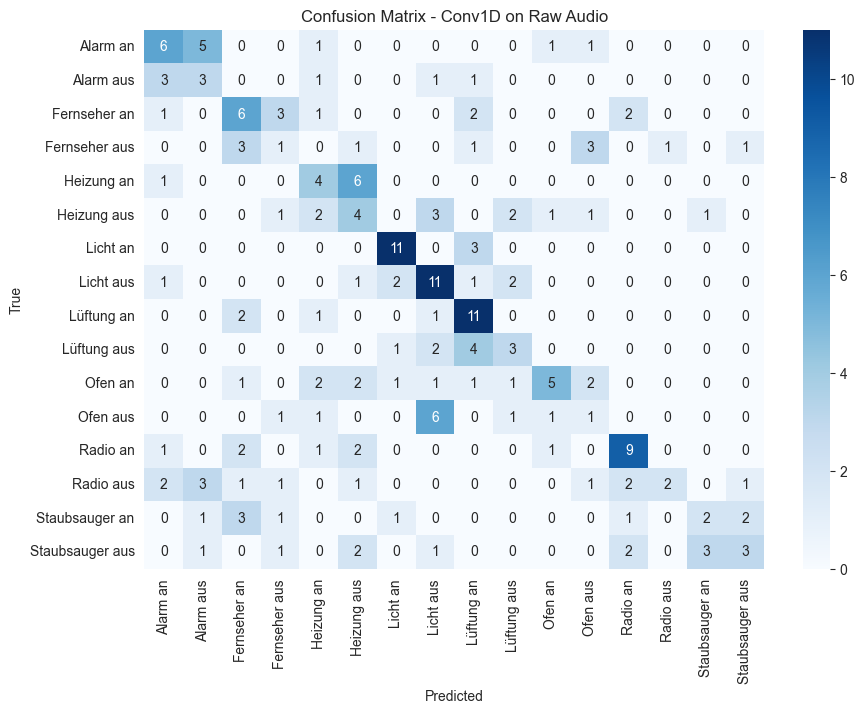

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on validation set
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Classification report
print("Conv1D Classifier Report on Raw Audio Data")
print(classification_report(y_val_labels, y_pred_labels, target_names=label_encoder.classes_, zero_division=0))

# Plot confusion matrix
cm = confusion_matrix(y_val_labels, y_pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Conv1D on Raw Audio')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Summary

This code uses your real audio data for training a Conv1D CNN. It includes:

- Loading and preprocessing the raw audio data.
- Reshaping the data to fit the Conv1D layer's expected input shape.
- Defining a Conv1D CNN model using `tensorflow.keras`.
- Training the model on your raw audio data.
- Evaluating the model's performance on the validation set.

You can now contrast the results from this model with those obtained using feature extraction to evaluate the benefits of feature extraction in your specific application.

### All-In-One:

In [1]:
data_dir = '../dataset'

2024-06-01 05:34:25.601923: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=800
  warnings.warn(


Max length determined statistically: 34021


/usr/local/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=800
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 34009, 8)            │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 11336, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11336, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 11326, 16)           │           1,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 3775, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3775, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 3767, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1255, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1255, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 1249, 64)            │          14,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 416, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 416, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 26624)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,816,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,871,536 (26.21 MB)

 Trainable params: 6,871,536 (26.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 336ms/step - accuracy: 0.1009 - loss: 2.8229 - val_accuracy: 0.2072 - val_loss: 2.4516
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 366ms/step - accuracy: 0.2924 - loss: 2.1732 - val_accuracy: 0.5822 - val_loss: 1.5067
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 70s 374ms/step - accuracy: 0.5468 - loss: 1.3825 - val_accuracy: 0.6707 - val_loss: 1.0936
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 72s 384ms/step - accuracy: 0.6903 - loss: 0.9583 - val_accuracy: 0.7525 - val_loss: 0.8611
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 363ms/step - accuracy: 0.7637 - loss: 0.7293 - val_accuracy: 0.8592 - val_loss: 0.5140
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 367ms/step - accuracy: 0.8342 - loss: 0.5136 - val_accuracy: 0.8598 - val_loss: 0.4906
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 67s 358ms/step - accuracy: 0.8667 - loss: 0.4082 - val_accuracy: 0.9007 - val_loss: 0.3452
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 72s 383ms/step - accuracy: 0.8899 - loss: 0

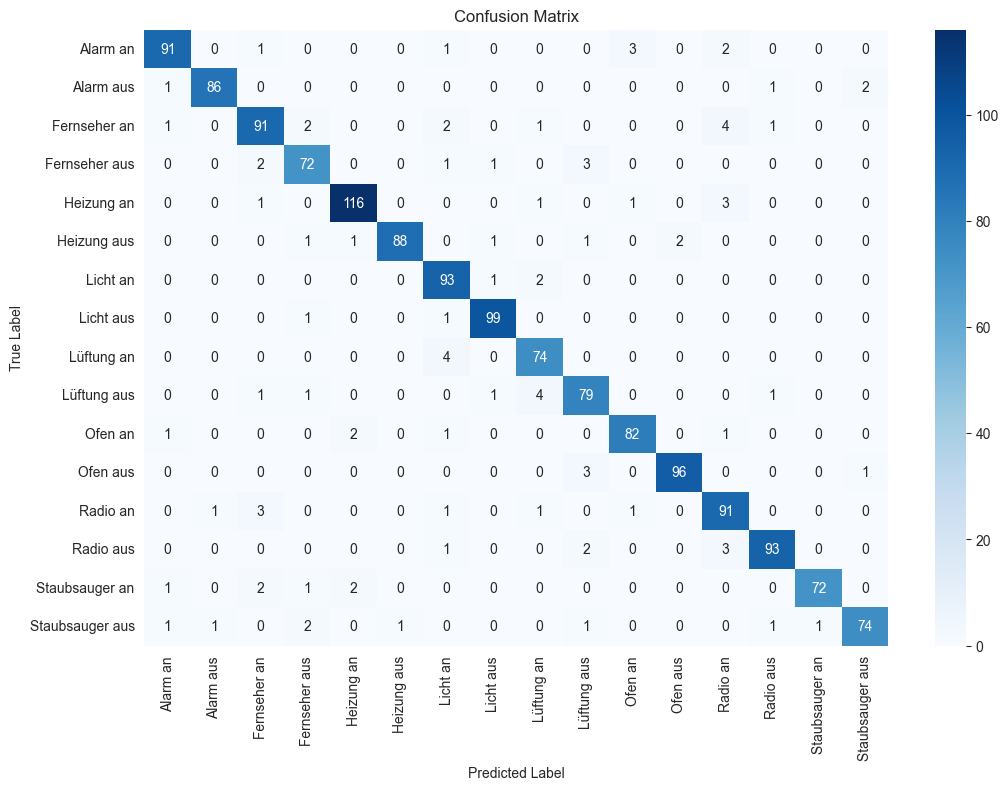

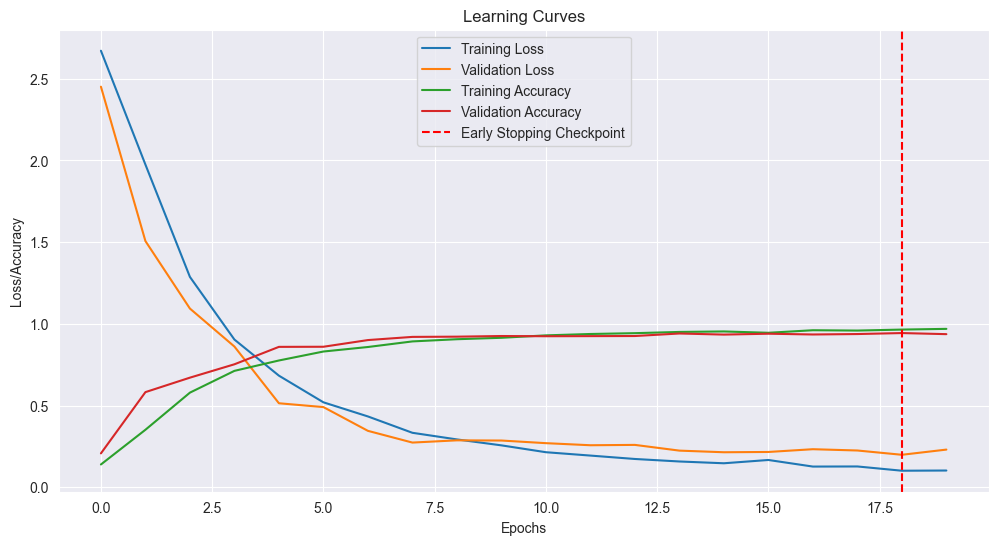

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9265 - loss: 0.2788
Previous model validation accuracy: 0.9315895438194275
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9247 - loss: 0.2627


Current model validation accuracy: 0.9369550347328186
Current model outperforms the previous model. Saving the current model.


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

#data_dir = '../dataset'
model_save_path = 'command_model.h5'

# Load the CSV file containing the annotations
annotations = pd.read_csv(f'{data_dir}/development_scene_annotations.csv')

# Function to check and handle NaNs and Infs
def check_and_handle_nans_infs(array):
    if np.isnan(array).any() or np.isinf(array).any():
        array = np.nan_to_num(array)
        array[np.isinf(array)] = 0
    return array

# Function to augment audio data
def augment_audio(audio, sample_rate):
    augmented_audio = []
    
    # Original
    augmented_audio.append(audio)
    
    # Add noise
    noise = np.random.randn(len(audio))
    audio_noise = audio + 0.005 * noise
    augmented_audio.append(audio_noise)

    # Time shift
    shift_range = int(sample_rate * 0.1)  # shift by up to 10% of sample rate
    shift = np.random.randint(-shift_range, shift_range)
    audio_shift = np.roll(audio, shift)
    augmented_audio.append(audio_shift)
    
    # Change pitch
    pitch_factor = np.random.uniform(-2, 2)
    audio_pitch = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=pitch_factor)
    augmented_audio.append(audio_pitch)
    
    # Time stretch
    stretch_factor = np.random.uniform(0.8, 1.2)
    audio_stretch = librosa.effects.time_stretch(audio, rate=stretch_factor)
    augmented_audio.append(audio_stretch)

    # Dynamic Range Compression
    audio_drc = librosa.effects.percussive(audio)
    augmented_audio.append(audio_drc)

    # Random Erasing (Zeroing out a part of the audio)
    erase_length = np.random.randint(0, int(len(audio) * 0.1))
    erase_start = np.random.randint(0, len(audio) - erase_length)
    audio_erased = audio.copy()
    audio_erased[erase_start:erase_start + erase_length] = 0
    augmented_audio.append(audio_erased)

    return augmented_audio

# First pass to determine max_length after augmentation
def first_pass(annotations):
    all_lengths = []

    for index, row in annotations.iterrows():
        file_name = f"{data_dir}/scenes/wav/{row['filename']}.wav"
        start_time = row['start']
        end_time = row['end']

        # Load audio file
        audio, sample_rate = librosa.load(file_name, sr=None)

        # Extract the relevant segment
        start_sample = int(start_time * sample_rate)
        end_sample = int(end_time * sample_rate)
        audio_segment = audio[start_sample:end_sample]

        # Normalize the audio segment
        audio_segment = librosa.util.normalize(audio_segment)

        # Apply data augmentation
        augmented_segments = augment_audio(audio_segment, sample_rate)
        
        for segment in augmented_segments:
            all_lengths.append(len(segment))

    return all_lengths

# Determine the maximum length after augmentation
lengths = first_pass(annotations)
max_length = int(np.percentile(lengths, 95))
print(f"Max length determined statistically: {max_length}")

# Second pass to preprocess and pad/crop audio segments
def second_pass(annotations, max_length):
    scaler = StandardScaler()
    ica = FastICA(n_components=1, whiten='unit-variance')
    audio_data = []
    labels = []

    for index, row in annotations.iterrows():
        file_name = f"{data_dir}/scenes/wav/{row['filename']}.wav"
        start_time = row['start']
        end_time = row['end']

        # Load audio file
        audio, sample_rate = librosa.load(file_name, sr=None)

        # Extract the relevant segment
        start_sample = int(start_time * sample_rate)
        end_sample = int(end_time * sample_rate)
        audio_segment = audio[start_sample:end_sample]

        # Normalize the audio segment
        audio_segment = librosa.util.normalize(audio_segment)

        # Apply data augmentation
        augmented_segments = augment_audio(audio_segment, sample_rate)
        
        for segment in augmented_segments:
            # Scale and apply ICA
            segment_scaled = scaler.fit_transform(segment.reshape(-1, 1)).flatten()
            segment_scaled = check_and_handle_nans_infs(segment_scaled)
            segment_ica = ica.fit_transform(segment_scaled.reshape(-1, 1)).flatten()
            segment_ica = check_and_handle_nans_infs(segment_ica)

            # Pad/crop to max_length
            if len(segment_ica) > max_length:
                segment_ica = segment_ica[:max_length]
            else:
                segment_ica = np.pad(segment_ica, (0, max_length - len(segment_ica)), 'constant')

            audio_data.append(segment_ica)
            labels.append(row['command'])

    return np.array(audio_data), labels

# Load and preprocess the audio data with padding/cropping
X, y = second_pass(annotations, max_length)

# Reshape the ICA output for Conv1D
X_ica_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert labels to categorical
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded, num_classes)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_ica_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define the Conv1D model
def create_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=8, kernel_size=13, padding='valid', activation='relu', strides=1),
        MaxPooling1D(pool_size=3),
        Dropout(0.3),
        Conv1D(filters=16, kernel_size=11, padding='valid', activation='relu', strides=1),
        MaxPooling1D(pool_size=3),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=9, padding='valid', activation='relu', strides=1),
        MaxPooling1D(pool_size=3),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=7, padding='valid', activation='relu', strides=1),
        MaxPooling1D(pool_size=3),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
model = create_model((X_train.shape[1], 1), num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Classification report
print("Conv1D Neural Network Classifier Report")
print(classification_report(y_val_classes, y_pred_classes, zero_division=0))

# Confusion matrix
conf_matrix = confusion_matrix(y_val_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Learning curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(np.argmin(history.history['val_loss']), color='r', linestyle='--', label='Early Stopping Checkpoint')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Load the previous best model and evaluate its performance
if os.path.exists(model_save_path):
    previous_model = load_model(model_save_path)
    previous_val_loss, previous_val_accuracy = previous_model.evaluate(X_val, y_val)
    print(f"Previous model validation accuracy: {previous_val_accuracy}")
else:
    previous_val_accuracy = 0
    print("No previous model found. Saving current model as the best model.")

# Compare the performance of the current model with the previous best model
current_val_loss, current_val_accuracy = model.evaluate(X_val, y_val)
print(f"Current model validation accuracy: {current_val_accuracy}")

if current_val_accuracy > previous_val_accuracy:
    print("Current model outperforms the previous model. Saving the current model.")
    model.save(model_save_path)
else:
    print("Previous model outperforms the current model. Keeping the previous model.")

# Code to experiment with model architecture and hyperparameters can be added here
# For example, you can try different numbers of filters, kernel sizes, dropout rates, etc.
# and compare the performance of the resulting models with the saved best model.

2024-06-02 11:05:24.179613: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 11:05:24.179883: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 11:05:24.183940: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 11:05:24.223666: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 11:05:24.941720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Max length determined statistically: 34038


/home/wolfram_e_laube/anaconda3/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=800
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 34026, 8)       │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11342, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11342, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 11332, 16)      │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3777, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3777, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 3769, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1256, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1256, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1250, 64)       │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 416, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 416, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 26624)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,816,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,871,536 (26.21 MB)

 Trainable params: 6,871,536 (26.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.0990 - loss: 2.8155 - val_accuracy: 0.2596 - val_loss: 2.3234
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.2683 - loss: 2.1657 - val_accuracy: 0.4822 - val_loss: 1.7324
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 130ms/step - accuracy: 0.4726 - loss: 1.5775 - val_accuracy: 0.6868 - val_loss: 1.1929
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.6371 - loss: 1.1282 - val_accuracy: 0.8115 - val_loss: 0.7137
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.7437 - loss: 0.7785 - val_accuracy: 0.8377 - val_loss: 0.5857
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.8199 - loss: 0.5509 - val_accuracy: 0.8739 - val_loss: 0.4528
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - accuracy: 0.8652 - loss: 0.4377 - val_accuracy: 0.9135 - val_loss: 0.3470
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - accuracy: 0.8913 - loss: 0

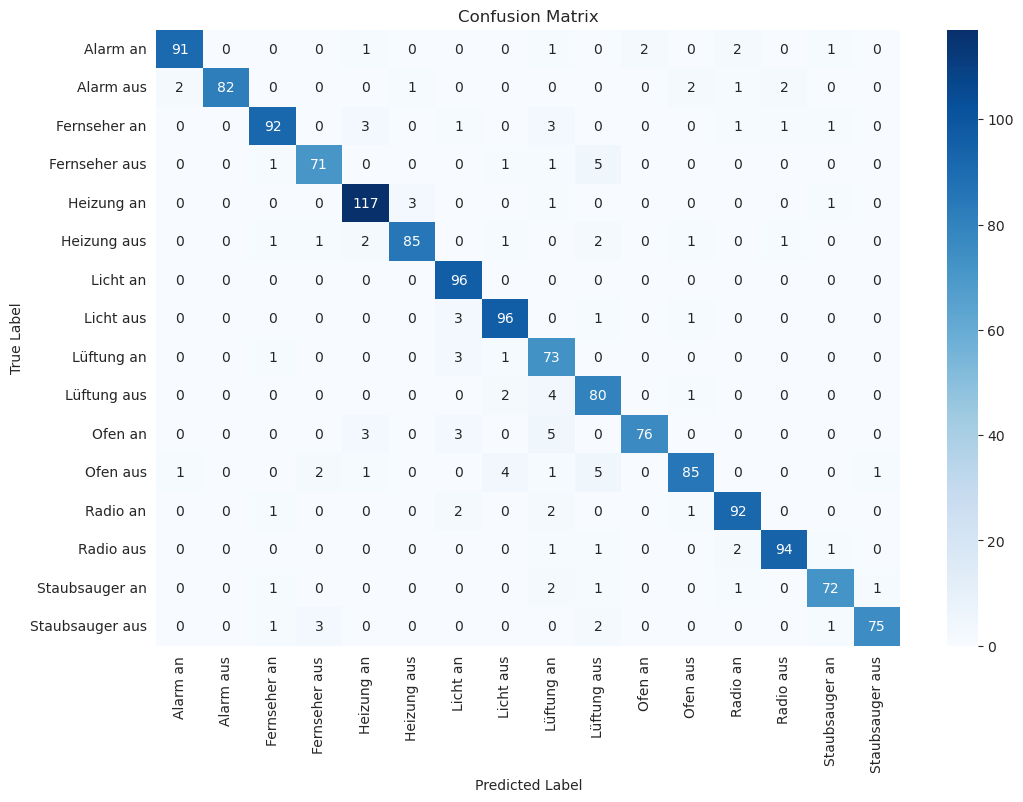

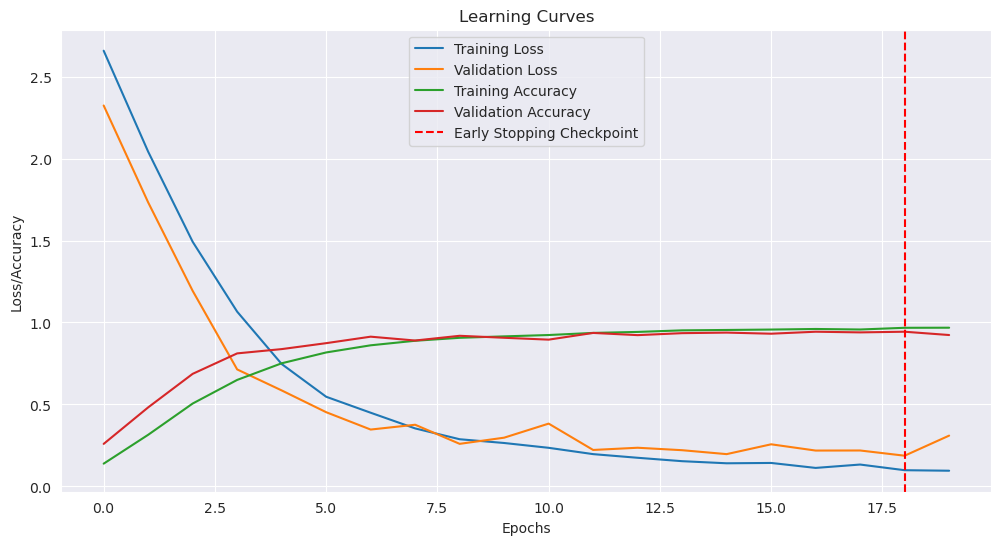

No previous model found. Saving current model as the best model.
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9259 - loss: 0.2907


Current model validation accuracy: 0.923541247844696
Current model outperforms the previous model. Saving the current model.


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

data_dir = '../dataset'
model_save_path = f'{data_dir}/command_model.h5'

# Load the CSV file containing the annotations
annotations = pd.read_csv(f'{data_dir}/development_scene_annotations.csv')

# Function to check and handle NaNs and Infs
def check_and_handle_nans_infs(array):
    if np.isnan(array).any() or np.isinf(array).any():
        array = np.nan_to_num(array)
        array[np.isinf(array)] = 0
    return array

# Function to augment audio data
def augment_audio(audio, sample_rate):
    augmented_audio = []
    
    # Original
    augmented_audio.append(audio)
    
    # Add noise
    noise = np.random.randn(len(audio))
    audio_noise = audio + 0.005 * noise
    augmented_audio.append(audio_noise)

    # Time shift
    shift_range = int(sample_rate * 0.1)  # shift by up to 10% of sample rate
    shift = np.random.randint(-shift_range, shift_range)
    audio_shift = np.roll(audio, shift)
    augmented_audio.append(audio_shift)
    
    # Change pitch
    pitch_factor = np.random.uniform(-2, 2)
    audio_pitch = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=pitch_factor)
    augmented_audio.append(audio_pitch)
    
    # Time stretch
    stretch_factor = np.random.uniform(0.8, 1.2)
    audio_stretch = librosa.effects.time_stretch(audio, rate=stretch_factor)
    augmented_audio.append(audio_stretch)

    # Dynamic Range Compression
    audio_drc = librosa.effects.percussive(audio)
    augmented_audio.append(audio_drc)

    # Random Erasing (Zeroing out a part of the audio)
    erase_length = np.random.randint(0, int(len(audio) * 0.1))
    erase_start = np.random.randint(0, len(audio) - erase_length)
    audio_erased = audio.copy()
    audio_erased[erase_start:erase_start + erase_length] = 0
    augmented_audio.append(audio_erased)

    return augmented_audio

# First pass to determine max_length after augmentation
def first_pass(annotations):
    all_lengths = []

    for index, row in annotations.iterrows():
        file_name = f"{data_dir}/scenes/wav/{row['filename']}.wav"
        start_time = row['start']
        end_time = row['end']

        # Load audio file
        audio, sample_rate = librosa.load(file_name, sr=None)

        # Extract the relevant segment
        start_sample = int(start_time * sample_rate)
        end_sample = int(end_time * sample_rate)
        audio_segment = audio[start_sample:end_sample]

        # Normalize the audio segment
        audio_segment = librosa.util.normalize(audio_segment)

        # Apply data augmentation
        augmented_segments = augment_audio(audio_segment, sample_rate)
        
        for segment in augmented_segments:
            all_lengths.append(len(segment))

    return all_lengths

# Determine the maximum length after augmentation
lengths = first_pass(annotations)
max_length = int(np.percentile(lengths, 95))
print(f"Max length determined statistically: {max_length}")

# Second pass to preprocess and pad/crop audio segments
def second_pass(annotations, max_length):
    scaler = StandardScaler()
    ica = FastICA(n_components=1, whiten='unit-variance')
    audio_data = []
    labels = []

    for index, row in annotations.iterrows():
        file_name = f"{data_dir}/scenes/wav/{row['filename']}.wav"
        start_time = row['start']
        end_time = row['end']

        # Load audio file
        audio, sample_rate = librosa.load(file_name, sr=None)

        # Extract the relevant segment
        start_sample = int(start_time * sample_rate)
        end_sample = int(end_time * sample_rate)
        audio_segment = audio[start_sample:end_sample]

        # Normalize the audio segment
        audio_segment = librosa.util.normalize(audio_segment)

        # Apply data augmentation
        augmented_segments = augment_audio(audio_segment, sample_rate)
        
        for segment in augmented_segments:
            # Scale and apply ICA
            segment_scaled = scaler.fit_transform(segment.reshape(-1, 1)).flatten()
            segment_scaled = check_and_handle_nans_infs(segment_scaled)
            segment_ica = ica.fit_transform(segment_scaled.reshape(-1, 1)).flatten()
            segment_ica = check_and_handle_nans_infs(segment_ica)

            # Pad/crop to max_length
            if len(segment_ica) > max_length:
                segment_ica = segment_ica[:max_length]
            else:
                segment_ica = np.pad(segment_ica, (0, max_length - len(segment_ica)), 'constant')

            audio_data.append(segment_ica)
            labels.append(row['command'])

    return np.array(audio_data), labels

# Load and preprocess the audio data with padding/cropping
X, y = second_pass(annotations, max_length)

# Reshape the ICA output for Conv1D
X_ica_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save the class names
command_class_names = list(label_encoder.classes_)
with open(f'{data_dir}/command_class_names.json', 'w') as f:
    json.dump(command_class_names, f)

# Convert labels to categorical
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded, num_classes)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_ica_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define the Conv1D model
def create_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=8, kernel_size=13, padding='valid', activation='relu', strides=1),
        MaxPooling1D(pool_size=3),
        Dropout(0.3),
        Conv1D(filters=16, kernel_size=11, padding='valid', activation='relu', strides=1),
        MaxPooling1D(pool_size=3),
        Dropout(0.3),
        Conv1D(filters=32, kernel_size=9, padding='valid', activation='relu', strides=1),
        MaxPooling1D(pool_size=3),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=7, padding='valid', activation='relu', strides=1),
        MaxPooling1D(pool_size=3),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
model = create_model((X_train.shape[1], 1), num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Classification report
print("Conv1D Neural Network Classifier Report")
print(classification_report(y_val_classes, y_pred_classes, zero_division=0))

# Confusion matrix
conf_matrix = confusion_matrix(y_val_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Learning curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(np.argmin(history.history['val_loss']), color='r', linestyle='--', label='Early Stopping Checkpoint')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Load the previous best model and evaluate its performance
if os.path.exists(model_save_path):
    previous_model = load_model(model_save_path)
    previous_val_loss, previous_val_accuracy = previous_model.evaluate(X_val, y_val)
    print(f"Previous model validation accuracy: {previous_val_accuracy}")
else:
    previous_val_accuracy = 0
    print("No previous model found. Saving current model as the best model.")

# Compare the performance of the current model with the previous best model
current_val_loss, current_val_accuracy = model.evaluate(X_val, y_val)
print(f"Current model validation accuracy: {current_val_accuracy}")

if current_val_accuracy > previous_val_accuracy:
    print("Current model outperforms the previous model. Saving the current model.")
    model.save(model_save_path)
else:
    print("Previous model outperforms the current model. Keeping the previous model.")


In [3]:
text_german_summary_shortened = """
### Stellenanforderungen
1. **Langjährige Python-Erfahrung**:
   - **Ihr Profil**: Umfangreiche Erfahrung mit Python, einschließlich TensorFlow und FastAI.

2. **Erfahrung mit Bibliotheken zur Daten-Verarbeitung (numpy, pandas, json, flask, dash)**:
   - **Ihr Profil**: Umfassende Kenntnisse in diesen Bibliotheken.

3. **Erfahrung mit Testing, Unittests, Testframeworks (unittest, pytest)**:
   - **Ihr Profil**: Erfahrung mit JUnit, JMeter und PyTest zeigt eine solide Grundlage.

4. **Datenbanken und DB-Interfaces (Oracle, PostgreSQL)**:
   - **Ihr Profil**: Bedeutende Erfahrung mit Oracle, PostgreSQL, MySQL und MongoDB.

5. **Verarbeitung von Zeitreihen**:
   - **Ihr Profil**: Erfahrung in der Zeitreihenanalyse und prädiktiven Wartung zeigt Ihre Kompetenz.

6. **Deployment (Jenkins, CI/CD)**:
   - **Ihr Profil**: Umfangreiche Erfahrung mit CI/CD-Pipelines, Jenkins, GitLab CI und anderen Tools.

7. **Dokumentation, Standards Style Guides**:
   - **Ihr Profil**: Erfahrung im Schreiben von Spezifikationen und technischer Dokumentation.

### Aufgabenbereiche
1. **Entwicklung im DevOps-Umfeld - Analytics Enablement**:
   - **Ihr Profil**: Starker Hintergrund in DevOps und Cloud-Architektur.

2. **Datenorchestrierung**:
   - **Ihr Profil**: Erfahrung mit Tools wie Kafka und RabbitMQ.

3. **Weiterentwicklung der Modellanwendungen**:
   - **Ihr Profil**: Erfahrung in der Entwicklung und Verbesserung von ML-Modellen.

4. **Wartung und Erweiterung bestehender Python-Bibliotheken**:
   - **Ihr Profil**: Erfahrung in der Wartung und Erweiterung von Python-Bibliotheken.

5. **Unterstützung bei der Migration von On-Premise-Anwendungen zur Cloud**:
   - **Ihr Profil**: Erfahrung mit Cloud-Migrationen, einschließlich AWS, Azure und Google Cloud.

6. **Überführung der Matlab-Modelle in Python**:
   - **Ihr Profil**: Beherrschung von Matlab und Python.

7. **Integration der Modelle**:
   - **Ihr Profil**: Erfahrung in der Integration verschiedener Modelle.

### Fazit
Ihr Profil passt gut zu den Anforderungen und Verantwortlichkeiten der Stelle. Ihre umfangreiche Erfahrung mit Python, Datenverarbeitungsbibliotheken, Testframeworks, Datenbanken, Deployment-Pipelines und Cloud-Plattformen macht Sie zu einem starken Kandidaten. Die Tiefe Ihrer Projekterfahrungen und Ihre kontinuierliche berufliche Weiterentwicklung unterstreichen Ihre Eignung.
"""

char_count = len(text_german_summary_shortened)
char_count


2365

In [4]:
import pandas as pd

# Load the idx_to_feature_names.csv
data_dir = '../dataset'
idx_to_feature_names_path = f'{data_dir}/meta/idx_to_feature_name.csv'

feature_names_df = pd.read_csv(idx_to_feature_names_path)
print(feature_names_df.head())


   index feature_name
0      0  bandwidth_0
1      1   centroid_0
2      2   contrast_0
3      3   contrast_1
4      4   contrast_2


In [20]:
import os
import numpy as np
import librosa
import logging
import pandas as pd
from tqdm import tqdm

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

data_dir = '../dataset'
audio_dir = f'{data_dir}/scenes/wav'
precompiled_feature_dir = f'{data_dir}/scenes/npy'
output_dir = f'{data_dir}/scenes/extracted_features_debug'
meta_dir = f'{data_dir}/meta'
annotations_file = f'{data_dir}/development_scene_annotations.csv'

os.makedirs(output_dir, exist_ok=True)
os.makedirs(meta_dir, exist_ok=True)

# Load annotations
logging.info('Loading annotations...')
annotations = pd.read_csv(annotations_file)
logging.info('Annotations loaded.')

# Function to extract features
def extract_features(y, sr):
    features = []
    feature_names = []
    feature_count = 0

    # Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    for i in range(mel_spec.shape[0]):
        features.append(mel_spec[i])
        feature_names.append(f'melspect_{i}')
        logging.info(f'Feature melspect_{i} shape: {mel_spec[i].shape}')
        feature_count += 1

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=32)
    for i in range(mfcc.shape[0]):
        features.append(mfcc[i])
        feature_names.append(f'mfcc_{i}')
        logging.info(f'Feature mfcc_{i} shape: {mfcc[i].shape}')
        feature_count += 1

    # Delta MFCC
    mfcc_delta = librosa.feature.delta(mfcc)
    for i in range(mfcc_delta.shape[0]):
        features.append(mfcc_delta[i])
        feature_names.append(f'mfcc_d_{i}')
        logging.info(f'Feature mfcc_d_{i} shape: {mfcc_delta[i].shape}')
        feature_count += 1

    # Delta-Delta MFCC
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    for i in range(mfcc_delta2.shape[0]):
        features.append(mfcc_delta2[i])
        feature_names.append(f'mfcc_d2_{i}')
        logging.info(f'Feature mfcc_d2_{i} shape: {mfcc_delta2[i].shape}')
        feature_count += 1

    # Spectral bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    for i in range(bandwidth.shape[0]):
        features.append(bandwidth[i])
        feature_names.append(f'bandwidth_{i}')
        logging.info(f'Feature bandwidth_{i} shape: {bandwidth[i].shape}')
        feature_count += 1

    # Spectral centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    for i in range(centroid.shape[0]):
        features.append(centroid[i])
        feature_names.append(f'centroid_{i}')
        logging.info(f'Feature centroid_{i} shape: {centroid[i].shape}')
        feature_count += 1

    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    for i in range(contrast.shape[0]):
        features.append(contrast[i])
        feature_names.append(f'contrast_{i}')
        logging.info(f'Feature contrast_{i} shape: {contrast[i].shape}')
        feature_count += 1

    # Spectral flatness
    flatness = librosa.feature.spectral_flatness(y=y)
    for i in range(flatness.shape[0]):
        features.append(flatness[i])
        feature_names.append(f'flatness_{i}')
        logging.info(f'Feature flatness_{i} shape: {flatness[i].shape}')
        feature_count += 1

    # Spectral flux
    flux = librosa.onset.onset_strength(y=y, sr=sr)
    flux = np.tile(flux, (mel_spec.shape[1], 1)).T  # Broadcast to match the number of time frames
    features.append(flux[0])
    feature_names.append('flux_0')
    logging.info(f'Feature flux_0 shape: {flux[0].shape}')
    feature_count += 1

    # Root mean square energy
    rms = librosa.feature.rms(y=y)
    for i in range(rms.shape[0]):
        features.append(rms[i])
        feature_names.append(f'energy_{i}')
        logging.info(f'Feature energy_{i} shape: {rms[i].shape}')
        feature_count += 1

    # Zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)
    for i in range(zcr.shape[0]):
        features.append(zcr[i])
        feature_names.append(f'zcr_{i}')
        logging.info(f'Feature zcr_{i} shape: {zcr[i].shape}')
        feature_count += 1

    # Power
    power = librosa.feature.rms(y=y)
    for i in range(power.shape[0]):
        features.append(power[i])
        feature_names.append(f'power_{i}')
        logging.info(f'Feature power_{i} shape: {power[i].shape}')
        feature_count += 1

    # Yin (pitch detection)
    yin = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    yin = np.tile(yin, (mel_spec.shape[1], 1)).T  # Broadcast to match the number of time frames
    features.append(yin[0])
    feature_names.append('yin_0')
    logging.info(f'Feature yin_0 shape: {yin[0].shape}')
    feature_count += 1

    # Harmonic
    harmonic = librosa.effects.harmonic(y)
    harmonic = librosa.feature.rms(y=harmonic)
    for i in range(harmonic.shape[0]):
        features.append(harmonic[i])
        feature_names.append(f'harmonic_{i}')
        logging.info(f'Feature harmonic_{i} shape: {harmonic[i].shape}')
        feature_count += 1

    # Chroma stft
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    for i in range(chroma_stft.shape[0]):
        features.append(chroma_stft[i])
        feature_names.append(f'chroma_stft_{i}')
        logging.info(f'Feature chroma_stft_{i} shape: {chroma_stft[i].shape}')
        feature_count += 1

    # Chroma cqt
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    for i in range(chroma_cqt.shape[0]):
        features.append(chroma_cqt[i])
        feature_names.append(f'chroma_cqt_{i}')
        logging.info(f'Feature chroma_cqt_{i} shape: {chroma_cqt[i].shape}')
        feature_count += 1

    # Chroma cens
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    for i in range(chroma_cens.shape[0]):
        features.append(chroma_cens[i])
        feature_names.append(f'chroma_cens_{i}')
        logging.info(f'Feature chroma_cens_{i} shape: {chroma_cens[i].shape}')
        feature_count += 1

    # Spectral rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    for i in range(rolloff.shape[0]):
        features.append(rolloff[i])
        feature_names.append(f'rolloff_{i}')
        logging.info(f'Feature rolloff_{i} shape: {rolloff[i].shape}')
        feature_count += 1

    return np.array(features), feature_names, feature_count

# Select a single file for debugging
file_name = '1008_speech_true_Ofen_an'
file_path = os.path.join(audio_dir, f"{file_name}.wav")
y, sr = librosa.load(file_path, sr=None)

# Extract features and save them
logging.info(f'Extracting features for {file_name}...')
features, feature_names, feature_count = extract_features(y, sr)
logging.info(f'Extracted features shape: {features.shape}')

# Save the extracted features
np.save(os.path.join(output_dir, file_name), features)

# Save feature names
with open(os.path.join(meta_dir, 'idx_to_extracted_feature_names.csv'), 'w') as f:
    for idx, name in enumerate(feature_names):
        f.write(f"{idx},{name}\n")

# Compare shapes with precompiled features
logging.info('Comparing shapes with precompiled features...')
precompiled_feature_path = os.path.join(precompiled_feature_dir, f"{file_name}.npy")
extracted_feature_path = os.path.join(output_dir, f"{file_name}.npy")

precompiled_features = np.load(precompiled_feature_path)
extracted_features = np.load(extracted_feature_path)

logging.info(f'{file_name} - Precompiled: {precompiled_features.shape}, Extracted: {extracted_features.shape}')
logging.info(f'Total number of features: {feature_count}')
logging.info('Shape comparison complete.')



2024-06-06 20:06:29,397 - INFO - Loading annotations...
2024-06-06 20:06:29,411 - INFO - Annotations loaded.
2024-06-06 20:06:29,419 - INFO - Extracting features for 1008_speech_true_Ofen_an...
2024-06-06 20:06:29,443 - INFO - Feature melspect_0 shape: (385,)
2024-06-06 20:06:29,444 - INFO - Feature melspect_1 shape: (385,)
2024-06-06 20:06:29,444 - INFO - Feature melspect_2 shape: (385,)
2024-06-06 20:06:29,445 - INFO - Feature melspect_3 shape: (385,)
2024-06-06 20:06:29,446 - INFO - Feature melspect_4 shape: (385,)
2024-06-06 20:06:29,446 - INFO - Feature melspect_5 shape: (385,)
2024-06-06 20:06:29,447 - INFO - Feature melspect_6 shape: (385,)
2024-06-06 20:06:29,447 - INFO - Feature melspect_7 shape: (385,)
2024-06-06 20:06:29,448 - INFO - Feature melspect_8 shape: (385,)
2024-06-06 20:06:29,449 - INFO - Feature melspect_9 shape: (385,)
2024-06-06 20:06:29,449 - INFO - Feature melspect_10 shape: (385,)
2024-06-06 20:06:29,450 - INFO - Feature melspect_11 shape: (385,)
2024-06-06 2

This utility script extracts features from a random choice of raw audio files into a folder and dumps shape information:

In [22]:
import os
import numpy as np
import pandas as pd
import random
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

data_dir = '../dataset'
output_dir = f'{data_dir}/scenes/extracted_features'
meta_dir = f'{data_dir}/meta'
annotations_file = f'{data_dir}/development_scene_annotations.csv'

# Load annotations
logging.info('Loading annotations...')
annotations = pd.read_csv(annotations_file)
logging.info('Annotations loaded.')

# Load feature names
feature_names_file = os.path.join(meta_dir, 'idx_to_extracted_feature_names.csv')
feature_names = []
with open(feature_names_file, 'r') as f:
    for line in f:
        index, name = line.strip().split(',')
        feature_names.append(name)

# Function to dump feature details
def dump_feature_details(file_name):
    feature_path = os.path.join(output_dir, f"{file_name}.npy")
    features = np.load(feature_path)

    logging.info(f"File: {file_name}")
    logging.info(f"Feature shape: {features.shape}")

    for idx, feature_name in enumerate(feature_names):
        if idx < features.shape[0]:
            logging.info(f"Feature {idx} ({feature_name}): shape {features[idx].shape}")

# Randomly select files
num_files_to_evaluate = 5
random_files = random.sample(list(annotations['filename'].unique()), num_files_to_evaluate)

# Dump feature details for randomly selected files
for file_name in random_files:
    dump_feature_details(file_name)


2024-06-06 20:49:09,079 - INFO - Loading annotations...
2024-06-06 20:49:09,118 - INFO - Annotations loaded.
2024-06-06 20:49:09,134 - INFO - File: 191_speech_false_Lüftung_an
2024-06-06 20:49:09,134 - INFO - Feature shape: (213, 381)
2024-06-06 20:49:09,135 - INFO - Feature 0 (melspect_0): shape (381,)
2024-06-06 20:49:09,135 - INFO - Feature 1 (melspect_1): shape (381,)
2024-06-06 20:49:09,136 - INFO - Feature 2 (melspect_2): shape (381,)
2024-06-06 20:49:09,136 - INFO - Feature 3 (melspect_3): shape (381,)
2024-06-06 20:49:09,137 - INFO - Feature 4 (melspect_4): shape (381,)
2024-06-06 20:49:09,138 - INFO - Feature 5 (melspect_5): shape (381,)
2024-06-06 20:49:09,138 - INFO - Feature 6 (melspect_6): shape (381,)
2024-06-06 20:49:09,139 - INFO - Feature 7 (melspect_7): shape (381,)
2024-06-06 20:49:09,139 - INFO - Feature 8 (melspect_8): shape (381,)
2024-06-06 20:49:09,139 - INFO - Feature 9 (melspect_9): shape (381,)
2024-06-06 20:49:09,140 - INFO - Feature 10 (melspect_10): shape 

This utility script calculates mean and standard deviation across a folder with extracted features:

In [25]:
import os
import numpy as np
import pandas as pd
import logging
from tqdm import tqdm

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

data_dir = '../dataset'
feature_dir = f'{data_dir}/scenes/extracted_features'
meta_dir = f'{data_dir}/meta'
annotations_file = f'{data_dir}/development_scene_annotations.csv'

# Load annotations
logging.info('Loading annotations...')
annotations = pd.read_csv(annotations_file)
logging.info('Annotations loaded.')

# Prepare feature-based command data
logging.info('Loading features for mean and std calculation...')
all_features = []
for index, row in tqdm(annotations.iterrows(), total=annotations.shape[0]):
    feature_path = os.path.join(feature_dir, row['filename'] + '.npy')
    features = np.load(feature_path)
    all_features.append(features)

# Concatenate along the correct axis
all_features = np.concatenate(all_features, axis=1)  # Concatenate along the time axis
mean = np.mean(all_features, axis=1, keepdims=True)
std = np.std(all_features, axis=1, keepdims=True)

# Handle any std values that are zero to avoid division by zero errors
std[std == 0] = 1e-8

logging.info(f'Mean shape: {mean.shape}, Std shape: {std.shape}')

# Save mean and std
np.save(os.path.join(meta_dir, 'mean.npy'), mean)
np.save(os.path.join(meta_dir, 'std.npy'), std)
logging.info('Mean and std saved.')


2024-06-06 21:35:02,892 - INFO - Loading annotations...
2024-06-06 21:35:02,898 - INFO - Annotations loaded.
2024-06-06 21:35:02,899 - INFO - Loading features for mean and std calculation...
100%|██████████| 1065/1065 [00:02<00:00, 511.48it/s]
2024-06-06 21:35:08,063 - INFO - Mean shape: (213, 1), Std shape: (213, 1)
2024-06-06 21:35:08,071 - INFO - Mean and std saved.


2024-06-07 09:41:39,085 - INFO - Loading annotations...
2024-06-07 09:41:39,095 - INFO - Annotations loaded.


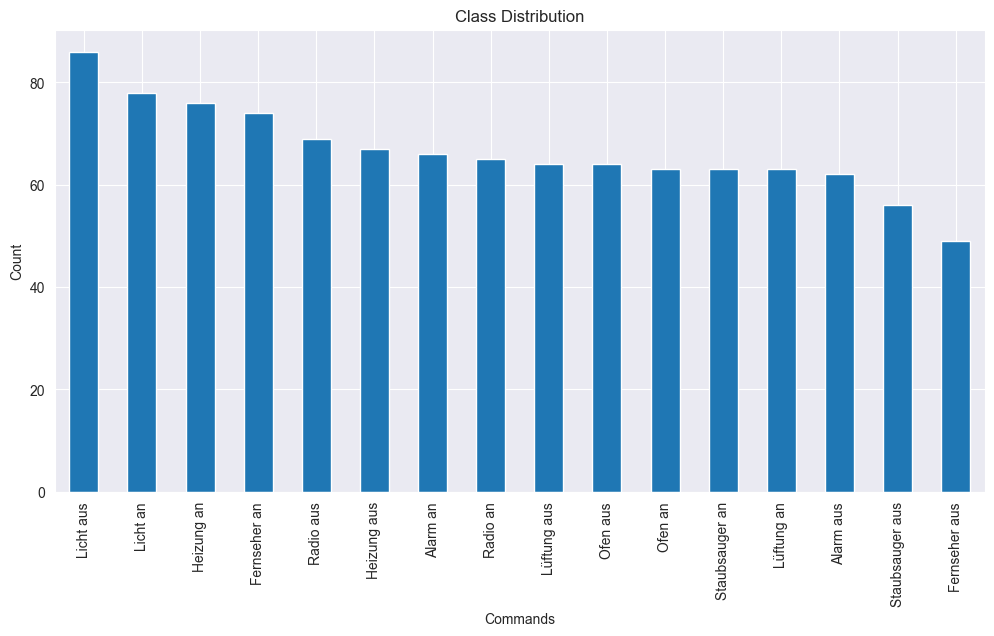

2024-06-07 09:41:39,400 - INFO - Preparing command data...
100%|██████████| 1065/1065 [00:01<00:00, 624.82it/s]
2024-06-07 09:41:43,532 - INFO - Command data prepared.
2024-06-07 09:41:50,834 - INFO - Command mapping: {'Licht aus': 0, 'Ofen an': 1, 'Radio an': 2, 'Fernseher an': 3, 'Heizung aus': 4, 'Alarm an': 5, 'Lüftung aus': 6, 'Staubsauger aus': 7, 'Heizung an': 8, 'Staubsauger an': 9, 'Alarm aus': 10, 'Licht an': 11, 'Ofen aus': 12, 'Radio aus': 13, 'Lüftung an': 14, 'Fernseher aus': 15}
2024-06-07 09:42:03,543 - INFO - Training command recognition model...


Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 322ms/step - accuracy: 0.0690 - loss: 2.8260 - val_accuracy: 0.1056 - val_loss: 2.7329
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/step - accuracy: 0.1637 - loss: 2.6670 - val_accuracy: 0.1455 - val_loss: 2.6929
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - accuracy: 0.2022 - loss: 2.5401 - val_accuracy: 0.1408 - val_loss: 2.6181
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step - accuracy: 0.2917 - loss: 2.3468 - val_accuracy: 0.1831 - val_loss: 2.5768
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 401ms/step - accuracy: 0.3364 - loss: 2.1459 - val_accuracy: 0.1854 - val_loss: 2.5121
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 389ms/step - accuracy: 0.4051 - loss: 1.9371 - val_accuracy: 0.2207 - val_loss: 2.3624
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - accuracy: 0.4909 - loss: 1.6902 - val_accuracy: 0.2700 - val_loss: 2.2773
Epoch 8/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 383ms/step - accuracy: 0.5478 - loss: 1.4370 - 

2024-06-07 10:02:34,323 - INFO - Command recognition model trained.


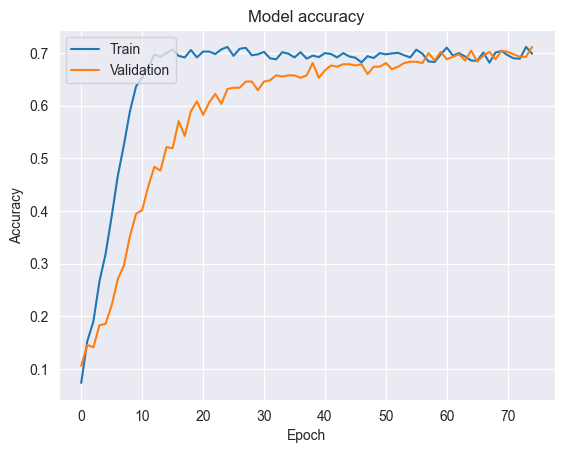

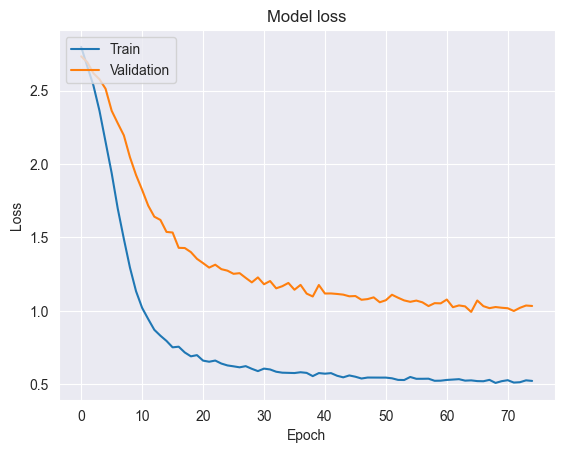

In [48]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import json

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

data_dir = '../dataset'
annotations_file = f'{data_dir}/development_scene_annotations.csv'
kan_model_save_path = 'best_command_kan_model.keras'
feature_dir = f'{data_dir}/scenes/extracted_features'
meta_dir = f'{data_dir}/meta'
command_mapping_path = os.path.join(meta_dir, 'command_mapping.json')

# Load annotations
logging.info('Loading annotations...')
annotations = pd.read_csv(annotations_file)
logging.info('Annotations loaded.')

# Load mean and std
mean = np.load(os.path.join(meta_dir, 'mean.npy'))
std = np.load(os.path.join(meta_dir, 'std.npy'))

# Check class distribution
class_counts = annotations['command'].value_counts()
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Commands')
plt.ylabel('Count')
plt.show()

def prepare_feature_data(annotations, feature_dir):
    command_features = []
    command_labels = []
    command_mapping = {}  # Mapping of command texts to numerical labels
    current_label = 0
    max_len = 0  # To determine the maximum length of features

    logging.info('Preparing command data...')
    for index, row in tqdm(annotations.iterrows(), total=annotations.shape[0]):
        feature_path = os.path.join(feature_dir, row['filename'] + '.npy')
        features = np.load(feature_path)

        if features.ndim == 1:  # Handling case where features are not properly loaded
            logging.warning(f"Feature file {row['filename']} has unexpected shape {features.shape} and will be skipped.")
            continue

        max_len = max(max_len, features.shape[1])  # Update max_len

        command_text = row['command']
        if command_text not in command_mapping:
            command_mapping[command_text] = current_label
            current_label += 1

        command_label = command_mapping[command_text]

        command_features.append(features)
        command_labels.append(command_label)

    # Pad features to the same length
    padded_features = []
    for feature in command_features:
        pad_width = max_len - feature.shape[1]
        if pad_width > 0:
            feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
        padded_features.append(feature)

    logging.info('Command data prepared.')
    return np.array(padded_features), np.array(command_labels), command_mapping, max_len

# Prepare feature-based command data
command_features, command_labels, command_mapping, max_len = prepare_feature_data(annotations, feature_dir)

# Save command mapping
with open(command_mapping_path, 'w') as f:
    json.dump(command_mapping, f)

# Normalize features across each feature dimension
command_features = (command_features - mean) / std

# One-hot encode labels
num_classes = len(command_mapping)
command_labels = to_categorical(command_labels, num_classes=num_classes)

logging.info(f'Command mapping: {command_mapping}')

# Data Augmentation Function
def augment_data(features, noise_factor=0.005):
    noise = np.random.randn(*features.shape) * noise_factor
    augmented_features = features + noise
    augmented_features = np.clip(augmented_features, -1.0, 1.0)
    return augmented_features

# Augment the training data
augmented_features = augment_data(command_features)
combined_features = np.concatenate((command_features, augmented_features), axis=0)
combined_labels = np.concatenate((command_labels, command_labels), axis=0)

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(np.argmax(command_labels, axis=1)),
                                                  y=np.argmax(command_labels, axis=1))
class_weights = dict(enumerate(class_weights))

# Kolmogorov-Arnold Network (KAN) Model
class KolmogorovArnoldNetwork(tf.keras.Model):
    def __init__(self, input_shape, num_univariate_functions, hidden_units, num_classes, **kwargs):
        super(KolmogorovArnoldNetwork, self).__init__(**kwargs)
        self.input_shape = input_shape
        self.num_univariate_functions = num_univariate_functions
        self.hidden_units = hidden_units
        self.num_classes = num_classes

        # Univariate functions layers
        self.univariate_layers = [layers.Dense(hidden_units, activation='tanh') for _ in range(num_univariate_functions)]

        # Combination layer
        self.combination_layer = layers.Dense(hidden_units, activation='relu')

        # Output layer
        self.output_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Apply univariate functions
        univariate_outputs = [layer(inputs) for layer in self.univariate_layers]

        # Combine outputs
        combined_output = tf.concat(univariate_outputs, axis=-1)
        combined_output = self.combination_layer(combined_output)

        # Flatten and apply final output layer
        combined_output = tf.reduce_mean(combined_output, axis=2)  # Average over feature dimension
        return self.output_layer(combined_output)

    def get_config(self):
        config = super(KolmogorovArnoldNetwork, self).get_config()
        config.update({
            'input_shape': self.input_shape,
            'num_univariate_functions': self.num_univariate_functions,
            'hidden_units': self.hidden_units,
            'num_classes': self.num_classes,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

input_shape = (command_features.shape[1], command_features.shape[2])
num_univariate_functions = 5
hidden_units = 128

kan_model = KolmogorovArnoldNetwork(input_shape, num_univariate_functions, hidden_units, num_classes)

kan_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

logging.info('Training command recognition model...')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(kan_model_save_path, save_best_only=True, monitor='val_loss')

history = kan_model.fit(combined_features, combined_labels, epochs=200, batch_size=48, validation_split=0.2,
                        callbacks=[early_stopping, model_checkpoint], class_weight=class_weights)
logging.info('Command recognition model trained.')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
